In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn
%matplotlib inline

In [2]:
def read_data(path):
    df = pd.read_csv(path, parse_dates=['FECHA'], infer_datetime_format=True)
    df['CPRECIO'] = df[' CPRECIO '].map(lambda x: x.strip().replace(",", ""))
    df['CPRECIO'] = df['CPRECIO'].convert_objects(convert_numeric=True)
    df['COSTOPESOS'] = df[' COSTOPESOS ']
    df = df.drop([' CPRECIO ', ' COSTOPESOS '], axis=1)
    cols = df.columns.values 
    cols[-3] = "YEAR"
    df.columns = cols
    return df

def read_test_data(path):
    df = pd.read_csv(path, parse_dates=['FECHA'], infer_datetime_format=True)
    df['CPRECIO'] = df[' CPRECIO ']
    df['COSTOPESOS'] = df[' COSTOPESOS ']
    df = df.drop([' CPRECIO ', ' COSTOPESOS '], axis=1)
    cols = df.columns.values 
    cols[-3] = "YEAR"
    df.columns = cols
    return df

def calculate_extra_cols(df):
    df['total_price'] =  df['CPRECIO'] * df['#UNIDADES'] * df['CTIPOCAM01']
    return df

In [3]:
df = read_data('./BASEVENTAS2010A2015.csv')
df = calculate_extra_cols(df)

/Users/Grimi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


### Lets start with the brands

In [4]:
# Cleanup all the spaces
df["MARCA"] = df["MARCA"].map(lambda x: x.strip())
df["IDPRODUCTO"] = df["IDPRODUCTO"].map(lambda x: x.strip())

In [5]:
# 5 most important Brands by quantity across 5 years
top5 = df.groupby("MARCA")["#UNIDADES"].sum().sort_values(ascending=False)[:5]
top5

MARCA
PHOENIX    1402560.96
IPS         362625.80
BANNER      102267.00
OMRON        56351.00
ABB          46322.00
Name: #UNIDADES, dtype: float64

#### Lets check the volume of the top brands

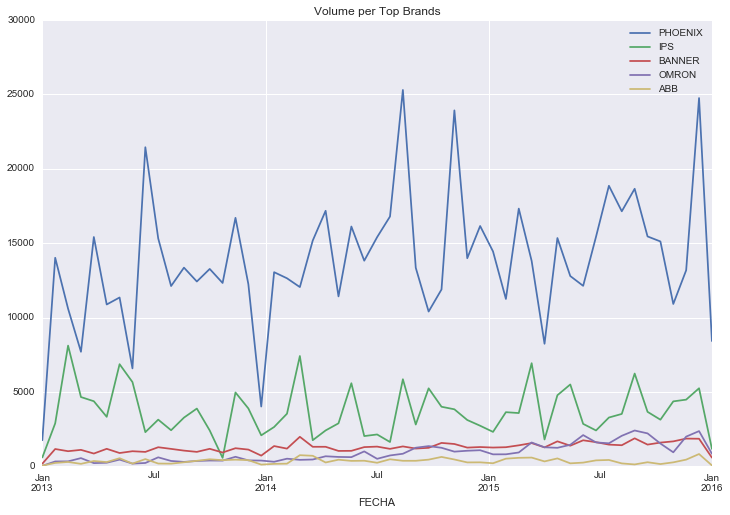

In [6]:
ts = df.set_index("FECHA")[["#UNIDADES", "MARCA", "total_price"]]
units_ts = ts[["#UNIDADES", "MARCA"]]
for brand in top5.index:
    new_ts = units_ts[units_ts["MARCA"] == brand]["#UNIDADES"]
    new_ts = new_ts["2013":].resample("3W").sum()
    new_ts.plot(ax=plt.gca(), label=brand, figsize=(12, 8))
plt.legend()
plt.title("Volume per Top Brands")
# brandts.plot(logy=True)

#### Top 5 brands by price

In [7]:
# 5 most important Brands by revenue across 5 years
top_b_p = df.groupby("MARCA")["total_price"].sum().sort_values(ascending=False)[:5]
top_b_p

MARCA
BANNER             1.663995e+08
PHOENIX            1.221179e+08
NO CLASIFICADOS    1.078702e+08
OMRON              7.790946e+07
PEPPERL+FUCHS      4.478326e+07
Name: total_price, dtype: float64

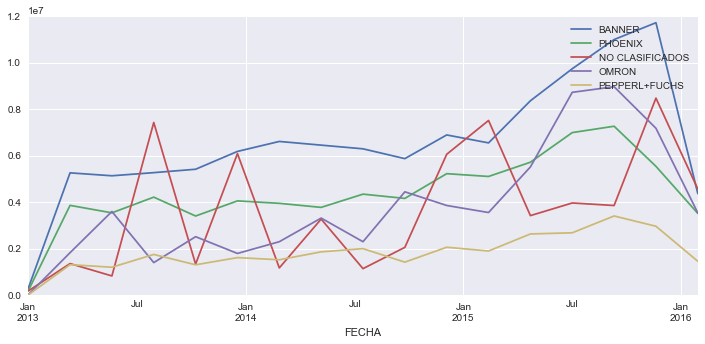

In [8]:
revenue_ts = ts[["total_price", "MARCA"]]
for brand in top_b_p.index[:5]:
    new_ts = revenue_ts[units_ts["MARCA"] == brand]["total_price"]
    new_ts = new_ts["2013":].resample("10W").sum()
    new_ts.plot(ax=plt.gca(), label=brand, figsize=(12, 5))
plt.legend()
# brandts.plot(logy=True)

### Now lets move to individual products

In [9]:
def get_top_products(n=5, by=None):
    new_df = df[((df["IDPRODUCTO"] != "FAC_PROY") | 
                (df["IDPRODUCTO"] != "ANTICIPO") | 
                (df["IDPRODUCTO"] != "SERVICIOS")) &
                (df["MARCA"] == "BANNER")]
    return new_df.groupby(["IDPRODUCTO", "PRODUCTO"])[by].sum().sort_values(ascending=False)[:n]
top_p_q = get_top_products(n=8, by="#UNIDADES") # Top products by units
top_p_r = get_top_products(n=8, by="total_price") # Top products by revenue
print "Top products by quantity", "\n", "-"*30
print top_p_q, "\n"
print "Top products by revenue", "\n", "-"*30
print top_p_r
# df.groupby(["IDPRODUCTO", "PRODUCTO"])["#UNIDADES"].sum()
# ts = df.set_index("FECHA")[["#UNIDADES", "MARCA", "total_price"]]

Top products by quantity 
------------------------------
IDPRODUCTO  PRODUCTO                      
25967       PBT46U FIBRA OPTICA PLASTICO      3253.0
28590       OTBVP6QD OPTO TOUCH               2367.0
26034       PIT46U FIBRA DE PLASTICO          1961.0
26850       MQDC-415 CABLE RECTO 4 PIN        1788.0
62382       D10DPFP AMPLIFICADOR P/FIBRA O    1783.0
73045       QS18VP6LDQ8 SENSOR LASER DIFUS    1650.0
70883       QDE-815D CABLE BANNER  4.5 Mts    1580.0
25226       MBCC-412 CABLE RECTO 4 PIN        1348.0
Name: #UNIDADES, dtype: float64 

Top products by revenue 
------------------------------
IDPRODUCTO  PRODUCTO                      
75639       SLSK30-600Q88-1RE15 KIT CORTIN    5.640533e+06
62382       D10DPFP AMPLIFICADOR P/FIBRA O    3.852295e+06
28590       OTBVP6QD OPTO TOUCH               3.165771e+06
74939       SLSK30-450Q88-1RE15 Kit CORTIN    3.036932e+06
73045       QS18VP6LDQ8 SENSOR LASER DIFUS    2.152170e+06
70231       QS30LDQ SENSOR LASER              2.

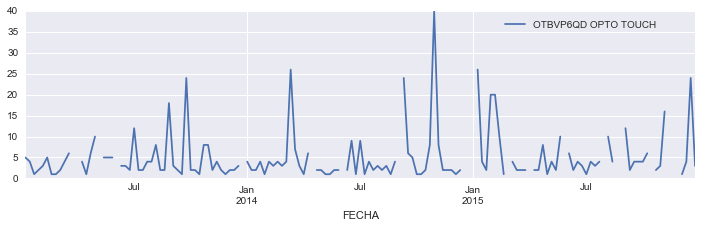

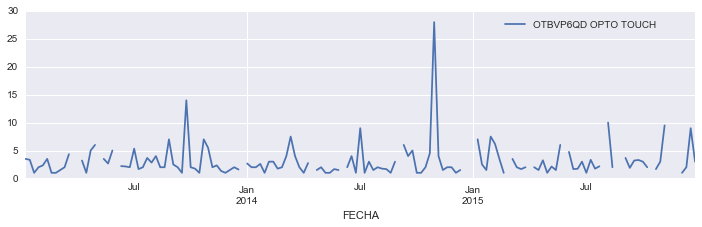

In [212]:
from statsmodels.tsa.stattools import adfuller
ts = df.set_index("FECHA")[["#UNIDADES", "IDPRODUCTO", "total_price"]]
units_ts = ts[["#UNIDADES", "IDPRODUCTO"]]
test_ts = None
for prod_id, product in top_p_q.index[1:2]:
    d_range_s = "2013"
    d_range_e = "2016"
    resample = "W"
    new_ts = units_ts[units_ts["IDPRODUCTO"] == prod_id]["#UNIDADES"]
    plt.figure()
    new_ts2 = new_ts[d_range_s:d_range_e].resample(resample).max()
    new_ts2.plot(label=product, figsize=(12, 3))
    plt.legend()
    plt.figure()
    new_ts3 = new_ts[d_range_s:d_range_e].resample(resample).mean()
    new_ts3.plot(label=product, figsize=(12, 3))
    test_ts = np.log(new_ts3)
    plt.legend()


In [213]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12, center=False).mean()
    rolstd = timeseries.rolling(window=12, center=False).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput 
    

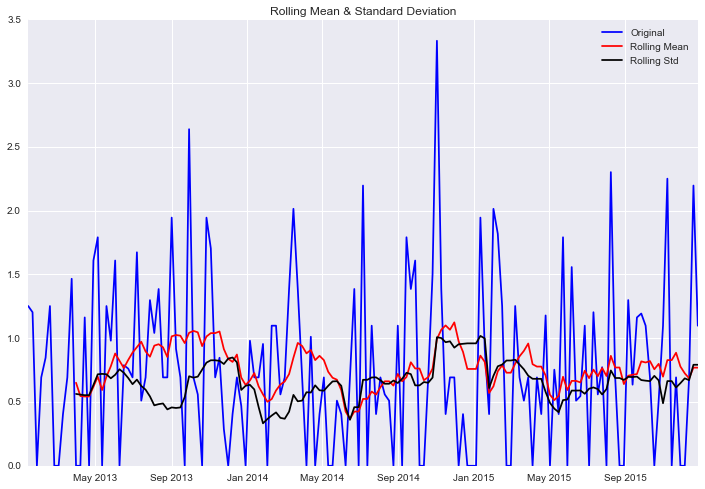

Results of Dickey-Fuller Test:
Test Statistic                -8.327704e+00
p-value                        3.434774e-13
#Lags Used                     2.000000e+00
Number of Observations Used    1.520000e+02
Critical Value (5%)           -2.880750e+00
Critical Value (1%)           -3.474121e+00
Critical Value (10%)          -2.577013e+00
dtype: float64


In [214]:
test_stationarity(test_ts.fillna(0))

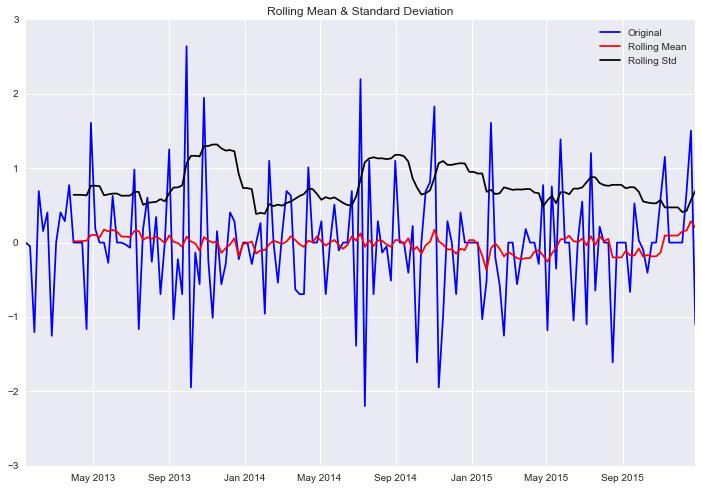

Results of Dickey-Fuller Test:
Test Statistic                -1.149283e+01
p-value                        4.690992e-21
#Lags Used                     2.000000e+00
Number of Observations Used    1.520000e+02
Critical Value (5%)           -2.880750e+00
Critical Value (1%)           -3.474121e+00
Critical Value (10%)          -2.577013e+00
dtype: float64


In [215]:
first_difference = test_ts - test_ts.shift(1)
test_stationarity(first_difference.fillna(0))

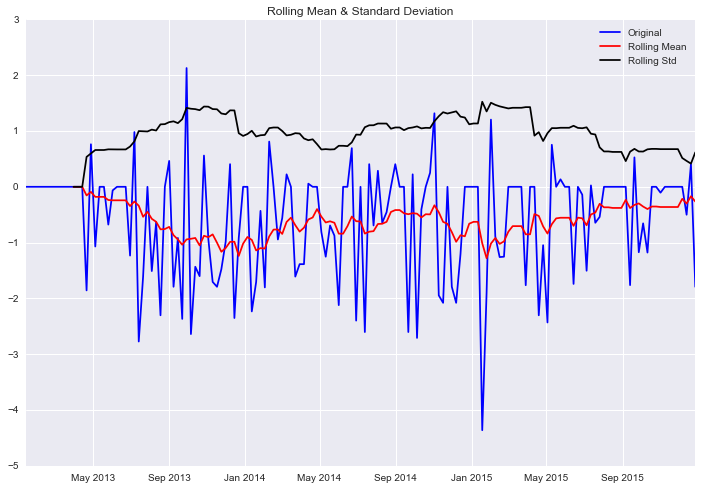

Results of Dickey-Fuller Test:
Test Statistic                  -2.401158
p-value                          0.141410
#Lags Used                       9.000000
Number of Observations Used    145.000000
Critical Value (5%)             -2.881688
Critical Value (1%)             -3.476273
Critical Value (10%)            -2.577513
dtype: float64


In [224]:
seasonal_difference = first_difference - test_ts.shift(11)
test_stationarity(seasonal_difference.fillna(0))

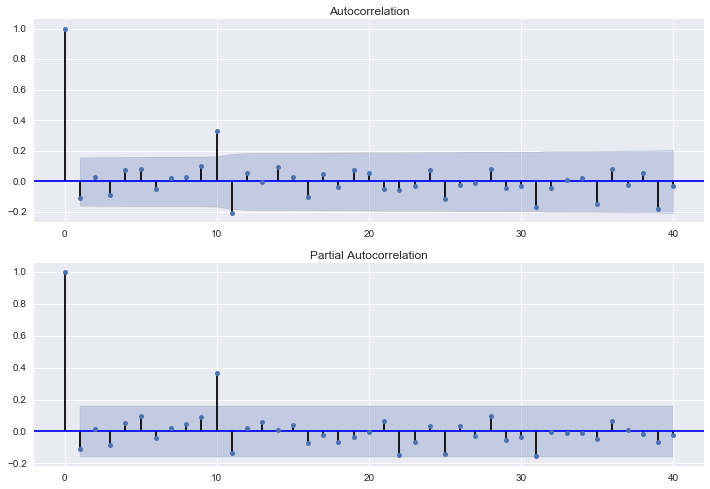

In [217]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_acf_pacf(your_data, lags):
   fig = plt.figure(figsize=(12,8))
   ax1 = fig.add_subplot(211)
   fig = plot_acf(your_data, lags=lags, ax=ax1)
   ax2 = fig.add_subplot(212)
   fig = plot_pacf(your_data, lags=lags, ax=ax2)
   plt.show()
    
plot_acf_pacf(seasonal_difference.fillna(0), 40)
# seasonal_difference.plot()

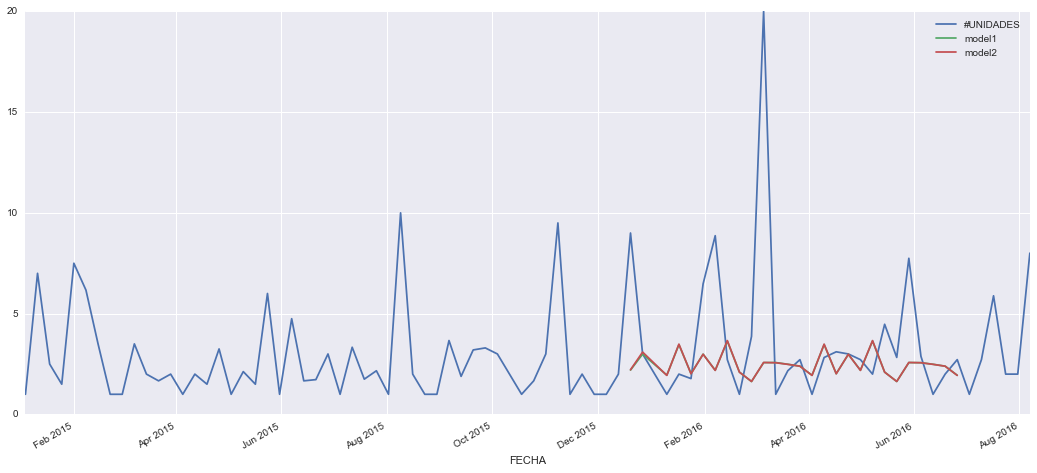

In [225]:
# import statsmodels.api as sm
# mod = SARIMAX(test_ts, trend='n', order=(0,1,0), seasonal_order=(1,1,1,12))
from statsmodels.tsa.statespace.sarimax import SARIMAX
from numpy import inf

# print model1.summary()
# print model2.summary()
df2 = read_test_data("./BASEVENTAS2016.csv")
ts2 = df2.set_index("FECHA")["#UNIDADES"]
ts2 = np.log(ts2.sort_index())
ts2[ts2 == -inf] = 0
ts2 = pd.DataFrame(ts2.resample("W").mean())
df2 = pd.DataFrame(test_ts.fillna(0))
new_df = pd.concat([df2, ts2.fillna(1)])

model1 = SARIMAX(test_ts, order=(1,0,0), seasonal_order=(1,1,1,12)).fit()
model2 = SARIMAX(test_ts, order=(0,0,1), seasonal_order=(1,1,1,12)).fit()
new_df['model1'] = model1.predict(start = 153, end= 180)  
new_df['model2'] = model2.predict(start = 153, end= 180)  
np.exp(new_df[new_df.index > "2015"]).plot(figsize=(18,8))

### Calculate metrics of my model

In [219]:
y_true = new_df[~new_df["model1"].isnull()]["#UNIDADES"]
y_pred_1 = new_df[~new_df["model1"].isnull()]["model1"]
y_pred_2 = new_df[~new_df["model1"].isnull()]["model2"]

In [220]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                          #UNIDADES   No. Observations:                  155
Model:             SARIMAX(1, 0, 0)x(1, 1, 1, 11)   Log Likelihood                -134.420
Date:                            Wed, 10 Aug 2016   AIC                            276.841
Time:                                    15:23:03   BIC                            289.014
Sample:                                01-13-2013   HQIC                           281.785
                                     - 12-27-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0882      0.110      0.805      0.421      -0.127       0.303
ar.S.L11      -0.1021      0.139     -0.735      0.462      -0.374       0.170
ma.S.L11      -0.9990     17.139     -0.058      0.954     -34.590      32.592
sigma2         0.4034      6.874      0.059      0.953     -13.069      13.876
===================================================================================
Ljung-Box (Q):                         nan   Jarque-Bera (JB):                 8.44
Prob(Q):                               nan   Prob(JB):                         0.01
Heteroskedasticity (H):               1.09   Skew:                             0.62
Prob(H) (two-sided):                  0.79   Kurtosis:                         3.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [221]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                          #UNIDADES   No. Observations:                  155
Model:             SARIMAX(0, 0, 1)x(1, 1, 1, 11)   Log Likelihood                -134.370
Date:                            Wed, 10 Aug 2016   AIC                            276.739
Time:                                    15:23:03   BIC                            288.913
Sample:                                01-13-2013   HQIC                           281.684
                                     - 12-27-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0968      0.105      0.921      0.357      -0.109       0.303
ar.S.L11      -0.1038      0.138     -0.752      0.452      -0.374       0.167
ma.S.L11      -0.9987     14.015     -0.071      0.943     -28.467      26.470
sigma2         0.4030      5.608      0.072      0.943     -10.589      11.395
===================================================================================
Ljung-Box (Q):                         nan   Jarque-Bera (JB):                 8.27
Prob(Q):                               nan   Prob(JB):                         0.02
Heteroskedasticity (H):               1.08   Skew:                             0.62
Prob(H) (two-sided):                  0.79   Kurtosis:                         3.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [226]:
df2.shape

(155, 1)